In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from geopy.geocoders import Nominatim
import time

from tools.functions import findWords
from tools.functions import countWord
from tools.functions import categorizeText

## Hipotesis: Las consecuencias del ataque de un tiburón son mayores cuando se le ha provocado

### Información adicional: Por pais, ¿que zonas son mas propensas a tener ataques de tiburones?
Distribución en el mapa de los ataquese por paises 


In [2]:
df_shark=pd.read_csv("input/GSAF5.csv", encoding="windows-1250")
df_shark.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [3]:
df_shark.shape

(5992, 24)

In [4]:
df_shark.isnull().sum()

Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64

In [5]:
df_shark["Unnamed: 22"].value_counts()

stopped here    1
Name: Unnamed: 22, dtype: int64

In [6]:
df_shark["Unnamed: 23"].value_counts()

Teramo             1
change filename    1
Name: Unnamed: 23, dtype: int64

### Se eliminan las columnas "Unnamed: 22" y "Unnamed: 23" por: 
1. tener solo una y dos filas rellenas repectivamente y 

2. imposibilidad de conocer el significado de estos datos (Los nombres de la columna no son explicativos)

In [7]:
df_shark=df_shark.drop(columns=['Unnamed: 22', 'Unnamed: 23'])
print(df_shark.columns)

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')


# Se corrige ennombre de las colmnas "Sex" y "Species" quitandoles el espacio del final.


In [8]:


df_shark=df_shark.rename(columns={'Sex ':'Sex','Species ':'Species', 'Fatal (Y/N)':'Fatal'})
df_shark.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal', 'Time', 'Species',
       'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order'],
      dtype='object')

# Se corrigen los valores de campo "Sex"

Se dejan solo los valores M (male), F (female), U (unknown)


In [9]:
df_shark["Sex"].value_counts()

M      4835
F       585
M         2
.         1
N         1
lli       1
Name: Sex, dtype: int64

In [10]:
unknow_sex=df_shark["Sex"].isnull()
wrong_sex=df_shark["Sex"].isin(['N','lli',"."])

df_shark.loc[unknow_sex | wrong_sex,"Sex"]="U"
df_shark.loc[df_shark["Sex"]=="M ","Sex"]="M"
df_shark["Sex"].value_counts()



M    4837
F     585
U     570
Name: Sex, dtype: int64

# Se corrigen los valores de campo "Fatal"

In [11]:
df_shark["Fatal"].value_counts()

N          4315
Y          1552
UNKNOWN      94
 N            8
n             1
N             1
#VALUE!       1
F             1
Name: Fatal, dtype: int64

In [12]:
list(df_shark.Fatal.value_counts().index)

['N', 'Y', 'UNKNOWN', ' N', 'n', 'N ', '#VALUE!', 'F']

In [13]:
unknow_fatal=df_shark["Fatal"].isnull()
wrong_fatal=df_shark["Fatal"].isin(['UNKNOWN','#VALUE!'])

df_shark.loc[unknow_fatal | wrong_fatal,"Fatal"]="U"
df_shark.loc[df_shark["Fatal"].isin([' N', 'n', 'N ', 'F']),"Fatal"]="N"
df_shark["Fatal"].value_counts()

N    4326
Y    1552
U     114
Name: Fatal, dtype: int64

# Obtener nivel de daño
A partir de la columna "Injury", se analiza las palabras mas frecuentes y su contexto habitual.
Según la palabra, se indica un nivel de daño generado por el ataque
El rango de daño va de 1 (No ha habido consecuencias) a 5 (Muerete)

In [14]:
df_shark.loc[df_shark.Injury.isnull(),"Injury"]="U"

### Se obtienen las palabras mas significativas

In [15]:
Injury_words=countWord(list(df_shark.Injury),3,10)



for key, value in sorted(Injury_words.items(), key=lambda item: item[1],reverse=True):
    print("%s: %s" % (key, value))

bitten: 1385
fatal: 831
right: 810
left: 807
foot: 715
lacerations: 560
provoked: 556
incident: 549
injury: 482
lacerated: 440
fatal,: 429
hand: 395
injury,: 374
board: 257
severed: 253
calf: 246
lacerati: 232
ankle: 219
minor: 212
lower: 189
puncture: 163
wounds: 158
fore: 157
recovered: 139
sharks: 139
hooked: 138
bitten,: 133
knee: 133
from: 130
severely: 121
injured: 118
were: 118
body: 115
injuries: 103
occupants,: 96
legs: 95
surgically: 88
amputated: 88
with: 86
surf: 82
shoulder: 76
remain: 76
drowning: 75
when: 74
severe: 71
torso: 70
heel: 69
involvemen: 67
taken: 67
occupants: 62
severed,: 61
wrist: 61
after: 61
bumped: 60
rammed: 56
have: 55
shark,: 54
abdomen: 52
swim: 52
chest: 51
been: 51
water: 49
back: 49
detail: 48
later: 48
found: 47
probab: 46
bite: 45
fingers: 45
head: 44
scavenging: 44
punctures: 43
struck: 42
grabbed: 42
finger: 42
buttock: 41
killed: 41
speared: 40
occupant,: 40
lacerated,: 40
elbow: 37
tail: 37
below: 37
kayak: 36
removed: 36
diver: 36
small: 3

In [16]:
### Se asocia un nivel de daño a cada palabra

In [41]:
damamage_levels={3:["drow","fatal","mput","sever"],2:["bite","bitten","injur"],1:["lacerat","minor","knock","incident","survived"]}
modificators=["no", "not"]
df_shark["damage_level"]=df_shark.Injury.apply(categorizeText,args=[damamage_levels,modificators])

In [49]:
df_shark.loc[df_shark.Injury.str.contains("no injur|No injur"),"damage_level"]=1
df_shark.loc[df_shark.Fatal=="Y","damage_level"]=3

In [50]:

Injury_words=countWord(list(df_shark.Injury[df_shark.damage_level=="U"]),3,10)

for key, value in sorted(Injury_words.items(), key=lambda item: item[1],reverse=True):
    print("%s: %s" % (key, value))
    

puncture: 98
shark: 94
wounds: 83
foot: 70
right: 65
left: 61
details: 43
thigh: 34
bruised: 19
ankle: 19
boat: 19
punctures: 19
recovered: 19
calf: 18
abrasions: 18
from: 16
board: 15
marks: 15
wound: 15
cuts: 13
sharks: 13
abraded: 13
with: 12
nipped: 12
bumped: 12
knee: 12
chest: 11
lower: 11
when: 10
fore: 10
involvement: 10
torn: 10
human: 10
injury: 10


### Utilizando los datos de la columna "Type" que nos indican las circunstancias en las que se produjo el ataque, se comparan las consecuencias de estos segun si el ataque  fue provocado o no.
### Se incluyen los ataques indicados como "Sea Disaster" en el grupo de provocados entendiendo que el tiburón podría estar en estado de aletra por una situación anomala.

In [51]:
df_shark.Type.value_counts()

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64

In [52]:
filter_proked=df_shark.Type.isin(["Provoked", "Sea Disaster"])
filter_unproked=df_shark.Type=="Unprovoked"
filter_known=df_shark["damage_level"]!="U"

provoked=df_shark.damage_level[filter_proked & filter_known].value_counts()
unprovoked=df_shark.damage_level[filter_unproked & filter_known].value_counts()

provoked=provoked/provoked.sum()
unprovoked=unprovoked/unprovoked.sum()


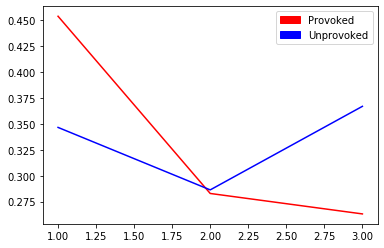

In [53]:
plt.plot([1,2,3],provoked.sort_index(),color='red')
plt.plot([1,2,3],unprovoked.sort_index(),color='blue' )
red_patch = mpatches.Patch(color='red', label="Provoked")
blue_patch = mpatches.Patch(color='blue', label="Unprovoked")
plt.legend(handles=[red_patch,blue_patch])


### Viendo esta gráfica, se concluye que provocar al tiburón no aumenta la probabilidad de sufrir un ataque mortal. EL echo de estar atento a las acciones del tiburón permite reducir el daño.
### Si el ataque no es previsto las consecuencias del ataque tienden a ser mayores



### Se analizan las cosecuencias de los ataques por paises.
Se toman los paises 10 con mas ataques

In [54]:
df_shark.Country.value_counts().index

Index(['USA', 'AUSTRALIA', 'SOUTH AFRICA', 'PAPUA NEW GUINEA', 'NEW ZEALAND',
       'BRAZIL', 'BAHAMAS', 'MEXICO', 'ITALY', 'FIJI',
       ...
       'GUATEMALA', 'KUWAIT', 'GHANA', 'MID-PACIFC OCEAN', 'GULF OF ADEN',
       'NEVIS', 'Sierra Leone', 'ANTIGUA', 'ST. MARTIN',
       'BRITISH VIRGIN ISLANDS'],
      dtype='object', length=203)

In [55]:
countrys=['USA', 'AUSTRALIA', 'SOUTH AFRICA', 'PAPUA NEW GUINEA', 'NEW ZEALAND','BRAZIL', 'BAHAMAS', 'MEXICO', 'ITALY', 'FIJI']
values=[]
for country in countrys:
    filter_country=df_shark.Country.isin([country])
    filter_known=df_shark["damage_level"]!="U"
    values.append(df_shark.damage_level[filter_country & filter_known].mean())
values

[1.6974921630094044,
 1.9206896551724137,
 1.8735632183908046,
 2.4015748031496065,
 1.853448275862069,
 2.3535353535353534,
 1.8478260869565217,
 2.5569620253164556,
 1.8870967741935485,
 2.293103448275862]

In [57]:
df = pd.DataFrame({'lab':countrys, 'val':values})
ax = df.plot.bar(x='Pais', y='Daño medio de los ataques', rot=45)

KeyError: 'Pais'

### En general, los ataque tiene las mismas nivel de consecuencias en todo los paises

## Distribución de ataques en cada pais
_(No esta terminado)_

In [26]:
#list(df_shark.Country.value_counts().index)


In [27]:

df_shark.loc[df_shark.Location.isnull(),"Location"]="U"
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SharkAttack")
location = geolocator.geocode("Arenales del Sol")
location



Location(Arenales del Sol, Els Arenals del Sol, Elx / Elche, el Baix Vinalopó, Alacant / Alicante, Comunitat Valenciana, España, (38.2511969, -0.520129111489151, 0.0))

In [28]:
lugares=list(df_shark.Location[df_shark.Country=="SPAIN"])

In [29]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SharkAttack")
geo_coord=[]
for lugar in lugares:
        geo_coord.append(geolocator.geocode(lugar))
        time.sleep(1.5)
    

In [30]:


geo_coord[3]

Location(Playa de Poniente, Avinguda de Vicent Llorca Alós, La Cala, Benidorm, la Marina Baixa, Alacant / Alicante, Comunitat Valenciana, 03502, España, (38.5321187, -0.157783476809866, 0.0))

In [31]:
longitude=list()
latitude=list()

for place in geo_coord:
    try:
        longitude.append(place[-1][0])
        latitude.append(place[-1][1])
    except:
        print("error pillado")

error pillado
error pillado
error pillado
error pillado
error pillado


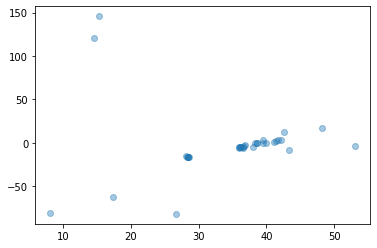

In [32]:

plt.scatter( x=longitude, y=latitude, alpha=0.4)
plt.show()

In [33]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Coordendas de Tenerife, en grados
lat, lon = 28.2419, -16.5937

# Mapa en alta resolución (h) con proyección mercator
map = Basemap(projection='merc', lat_0 = lat, lon_0 = lon,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=lon-0.5, llcrnrlat=lat-0.5,
    urcrnrlon=lon+0.5, urcrnrlat=lat+0.5)

# Líneas de costas y paises, aunque en este ejemplo no se ven
map.drawcoastlines()
map.drawcountries()

map.fillcontinents(color = '#cc9966')
map.drawmapboundary()

# Coordenadas para dibujar en el map
lats = [28.5068, 28.2617, 28.3310]
lons = [-16.2531, -16.5526, -16.8353]

x,y = map(lons, lats)
map.plot(x, y, '*r', markersize=6)

plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
list(df_shark.href[df_shark.Fatal=="Y"])